# Lab 2: One hidden neural network with finite-sample expressivity

This lab studies a one hidden neural network with $N$ hidden neurons that can approximate any finite set with $N$ samples.

Author: Lionel Fillatre

# Objective

For weight vectors $w,b\in \mathbb{R}^N$ and $a\in \mathbb{R}^n$, we consider the function $f:\mathbb{R}^n \rightarrow \mathbb{R}$,
$$
f(x)=\sum_{j=1}^{N}w_j \max\{a^Tx-b_j,0\}.
$$

Let $S$ be any sample $S = \{x_1,\ldots,x_N\}$ of size $N$ with $x_i \in\mathbb{R}^n$ and some target vectors $y_i \in \mathbb{R}$.
It is assumed that all the $x_i's$ are distinct.

We want to find weights $a$, $b$, $w$ so that $y_i = f(x_i)$ for all $i \in \{1,\ldots,N\}$.

### Question 1:

Verify that $f(x)$ can be expressed by a depth $2$ network (one hidden layer only) with ReLU activations.

Write your answer here.

### Answer 1:

The claim is straightforward.

In [1]:
import torch
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
seed = 79790
torch.manual_seed(seed) # set the seed of the random generator

# Data generation

### Question 2:

As a numerical example to test our mathematical results, we simulate some synthetic samples. Use ``torch.randn'' to generate the random samples $x_i$. Each $x_{i,j}$ must follow the distribution $\mathcal{N}(0,\frac{1}{n})$. You can generate $N=5$ random samples with $n=2$.

In [3]:
# Write your code here.

### Answer 2: 

Generate the samples

In [4]:
N = 5 # number of samples for the training
n = 2

X = 1/np.sqrt(n)*torch.randn(N, n)
print(X.shape)

# compute the norm of the square rows
sumX2 = torch.sum(X**2, 1)
print(sumX2.mean())

torch.Size([5, 2])
tensor(0.6308)


### Question 3:

We also simulate the labels. For each $x_i$, generate the label $y_i$ as
		$$
		y_i=\min\left\{10,\max\left\{1,\frac{1}{n}\sum_{j=1}^{n}  \left|\sinh( n^2\,x_{i,j}) \right| \right\}\right\}.
		$$

In [5]:
# Write your code here.

### Answer 3: Generate the labels

In [6]:
def generate_target(X):
    S = torch.mean(torch.abs(torch.sinh(((n**2)*X))),1)
    Y = torch.clamp(S, min=1, max=10).view(-1,1)
    return Y

Y = generate_target(X)
print(Y)
print(Y.shape)

tensor([[ 2.1582],
        [ 8.6118],
        [10.0000],
        [ 2.9842],
        [ 1.6595]])
torch.Size([5, 1])


# Neural network parameters 

### Question 4:

Show that we can find $a\in\mathbb{R}^n$ such that, with $z_i = a^Tx_i$, we have $z_i\neq z_j$ for all $1\leq i\neq j\leq N$. In the rest of the exercise, we assume that $z_1  < z_2 < \ldots < z_N$ (even if we swap the $x_i$'s and the $y_i$'s).
			
Hint: a finite union of hyperplanes in $\mathbb{R}^n$ can not cover $\mathbb{R}^n$.

Write your answer here.

### Answer 4:

It is clear that $z_i\neq z_j$ if and only if $a^T(x_i-x_j)\neq 0$. Hence, $a$ should not belong to the hyperplane $H_{i,j}$ whose normal vector is $x_i-x_j\neq 0$ (because the $n$ vectors $x_i's$ are distinct).

Hence, we must find a vector $a$ which does not belong to $\cup_{i\neq j}H_{i,j}$.

Since a finite union of hyperplanes can not cover $\mathbb{R}^n$, we can find a vector $a$. 

### Question 5:

Imagine a random mecanism to generate $a$. Generate $a$ in Python.

In [7]:
# Write your code here.

### Answer 5:

Generate the vector as a random Gaussian vector because its probability to belong to $\cup_{i\neq j}H_{i,j}$ is tiny.

In [8]:
a = torch.randn(n,1)
print(a)
print(a.shape)

tensor([[ 0.1177],
        [-1.3662]])
torch.Size([2, 1])


### Question 6:

Show that we can find $a$ and $b$ such that, with $z_i = a^Tx_i$, we have the interleaving property $b_1 < z_1 < b_2 < z_2 < \ldots < b_N < z_N$.

Write your answer here.

### Answer 6:

We can find $a\in\mathbb{R}^d$ such that $z_1  < z_2 < \ldots < z_n$. It is then easy to find an interleaving sequence of $b_j$'s. For example, $b_1=z_1-1$ and $b_i=(z_{i-1}+z_i)/2$ for $2\leq i \leq N$.

### Question 7:

Compute the $z_i$'s in Python.

In [9]:
# Write your code here.

### Answer 7:

Generate the values $z_i$ and sort them.

In [10]:
Z=X.mm(a)
Z = torch.squeeze(Z, 1)
print(Z.shape)

Asort = torch.argsort(Z, dim=0)
Zsort = Z[Asort]
print(Zsort)
print(Zsort.shape)

torch.Size([5])
tensor([-0.5108,  0.2979,  0.6959,  0.8192,  1.2136])
torch.Size([5])


### Question 8:

Compute the $b_i$'s in Python.

In [11]:
# Write your code here.

### Answer 8:

We compute the $b_i$'s.

In [12]:
mid = 0.5*(Zsort[1:]+Zsort[:-1])
print(mid.shape)
b0 = Zsort[0] - 1
b0 = torch.unsqueeze(b0, dim=0)
b = torch.cat((b0,mid),0)
print(b.shape)
print(b)

torch.Size([4])
torch.Size([5])
tensor([-1.5108, -0.1065,  0.4969,  0.7575,  1.0164])


### Question 9:

Show that the $N \times N$ matrix $A =\left( a_{i,j} \right)$ with  $a_{i,j}=\max\{z_i-b_j , 0\}$ is lower triangular.

Write your answer here.

### Answer 9:

By its definition, the matrix $A$ is lower triangular, that is, all entries with $i < j$ vanish. 

### Question 10:

Compute the matrix $A$ in Python.

In [13]:
# Write your code here.

### Answer 10:

Generate the matrix $A$

In [14]:
Zr = Zsort.view(-1,1).repeat(1,N)
br = b.view(1,-1).repeat(N,1)
print(Zr.shape)
print(br.shape)
Ar = Zr-br
A = torch.tril(Ar, diagonal=0)
print(A)

torch.Size([5, 5])
torch.Size([5, 5])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.8087, 0.4044, 0.0000, 0.0000, 0.0000],
        [2.2067, 0.8024, 0.1990, 0.0000, 0.0000],
        [2.3300, 0.9257, 0.3223, 0.0617, 0.0000],
        [2.7245, 1.3201, 0.7167, 0.4561, 0.1972]])


### Question 11:

Show that $A$ has full rank.

Write your answer here.

### Answer 11:

A basic linear algebra fact states that a lower-triangular matrix has full rank (i.e., is invertible) if and only if all of the entries on the diagonal are nonzero. 

Since, $x_i > b_i$, we have that $\max\{x_i-b_i , 0\}>0$. Hence, A is invertible.

### Question 12:

Compute the determinant of $A$ in Python.

In [15]:
# Write your code here.

### Answer 12:

Compute the determinant to check the invertibility of the matrix $A$.

In [16]:
detA = torch.prod(torch.diagonal(A, 0))
print(detA)

tensor(0.0010)


### Question 13:

Consider the set of $N$ equations $y_i=f(x_i)$ for $i \in \{1,\ldots,N\}$. Show that $f(x_i) = A_i w$ where $A_i$ is the $i$-th row of $A$.

Write your answer here.

### Answer 13:

The claim is straightforward since $a^Tx_i=z_i$.

### Question 14:

Show that we can find $w$ such that $y_i = f(x_i)$ for all $i \in \{1,\ldots,N\}$.

Write your answer here.

### Answer 14:

We chose $a$ and $b$ so that $A$ has full rank. We can now solve the linear system $y = Aw$ to find suitable weights $w$. 

### Question 15:

Compute the optimal $w$ in Python.

In [17]:
# Write your code here.

### Answer 15:

Compute the optimal weights of the one-hidden neural network.

In [18]:
Ysort = Y[Asort]
Xsort = X[Asort,:]
wopt = torch.linalg.solve(A, Ysort)
print(wopt)

tensor([[   1.6595],
        [  17.3070],
        [ -77.3399],
        [ 130.1448],
        [-115.0084]])


# Neural network implementation

### Question 16:

Write a neural network class "Net(nn.Module)" which implements the depth 2 network with the parameters you have computed in the previous cells.

In [19]:
# Write your code here.

### Answer 16:

Define a one hidden neural network

In [20]:
import torch.nn.functional as F

class OneHiddenNN(torch.nn.Module):
    def __init__(self, n, h):
        super().__init__()
        self.hidden = torch.nn.Linear(n, h)
        self.output = torch.nn.Linear(h, 1)

    def oracle_init(self, wo, wh, bh):
        # Initialization of the neural network
        self.output.weight.data = torch.clone(wo.view(1,-1)) 
        self.output.bias.data = torch.tensor([0.0])
        self.hidden.weight.data = torch.clone(wh.view(1,-1).repeat(N,1))
        self.hidden.bias.data = -torch.clone(bh)
    
    def forward(self, x):
        x = self.hidden(x)
        x = torch.relu(x)
        x = self.output(x)
        return x
    
# Neural network instanciation
model_hand = OneHiddenNN(n, N)
loss_function = torch.nn.MSELoss()

# Initialisation with some optimal parameters
model_hand.oracle_init(wopt,a,b)

### Question 17:

Generate a test set with the same size as the training set. Compare the training loss and the test loss.

In [21]:
# Write your code here.

### Answer 17:

Let us compare the losses on a test set.

In [22]:
# Generation of test samples
Xtest = 1/np.sqrt(n)*torch.randn(N, n)
Ytest = generate_target(Xtest)

# Train set
Yhat = model_hand(X)
loss = loss_function(Yhat, Y)
print(loss)

# Test set
Yhat = model_hand(Xtest)
loss = loss_function(Yhat, Ytest)
print(loss)


tensor(5.5707e-13, grad_fn=<MseLossBackward0>)
tensor(88.1685, grad_fn=<MseLossBackward0>)


# Bonus:

We train a neural network from a random initialization and compare it to the previous neural network.

In [23]:
model = OneHiddenNN(n, N)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss, test_loss = [], []
nbepoch = 1000 # Number of epochs

for epoch in range(nbepoch): ## run the model for 10 epochs

    optimizer.zero_grad()
    ## 1. forward propagation
    output = model(X)
    
    # Result on the test set
    outputTest = model(Xtest)
    lossTest = loss_function(outputTest, Ytest)
    test_loss.append(lossTest.item())
        
    ## 2. loss calculation
    loss = loss_function(output, Y)
        
    ## 3. backward propagation
    loss.backward()
        
    ## 4. weight optimization
    optimizer.step()
        
    train_loss.append(loss.item())
    
    if (epoch % 50) == 0:
        print ("Epoch:", epoch, "Training Loss: ", (loss.item()))

Epoch: 0 Training Loss:  35.93419647216797
Epoch: 50 Training Loss:  4.126924991607666
Epoch: 100 Training Loss:  1.8737423419952393
Epoch: 150 Training Loss:  1.5527673959732056
Epoch: 200 Training Loss:  1.37189519405365
Epoch: 250 Training Loss:  1.2210630178451538
Epoch: 300 Training Loss:  1.0877878665924072
Epoch: 350 Training Loss:  0.9559024572372437
Epoch: 400 Training Loss:  0.8256281614303589
Epoch: 450 Training Loss:  0.6995629072189331
Epoch: 500 Training Loss:  0.5807396769523621
Epoch: 550 Training Loss:  0.4719986021518707
Epoch: 600 Training Loss:  0.37553268671035767
Epoch: 650 Training Loss:  0.2926039695739746
Epoch: 700 Training Loss:  0.2234695851802826
Epoch: 750 Training Loss:  0.16749699413776398
Epoch: 800 Training Loss:  0.12339556217193604
Epoch: 850 Training Loss:  0.09084846079349518
Epoch: 900 Training Loss:  0.06931430101394653
Epoch: 950 Training Loss:  0.054874517023563385


Print the loss with respect to the epoch

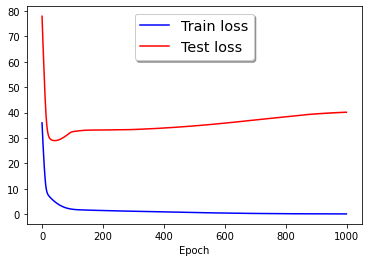

In [24]:
T = range(nbepoch)
figure = plt.figure()
b1 = plt.plot(T, train_loss, 'b-', label='Train loss')
b2 = plt.plot(T, test_loss, 'r-', label='Test loss')
plt.xlabel('Epoch')
plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.show()

Print the parameters of the learned neural network

In [25]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

hidden.weight tensor([[ 0.3484,  0.3147],
        [ 0.8679, -0.1029],
        [ 1.5717, -1.0192],
        [ 0.5172, -0.1034],
        [ 2.2336, -2.8602]])
hidden.bias tensor([-0.6407,  0.2703,  0.2970,  0.4063, -2.1024])
output.weight tensor([[-0.0689,  0.8772,  1.7967,  0.4139,  4.1006]])
output.bias tensor([0.5293])
